# Predicting Car Prices

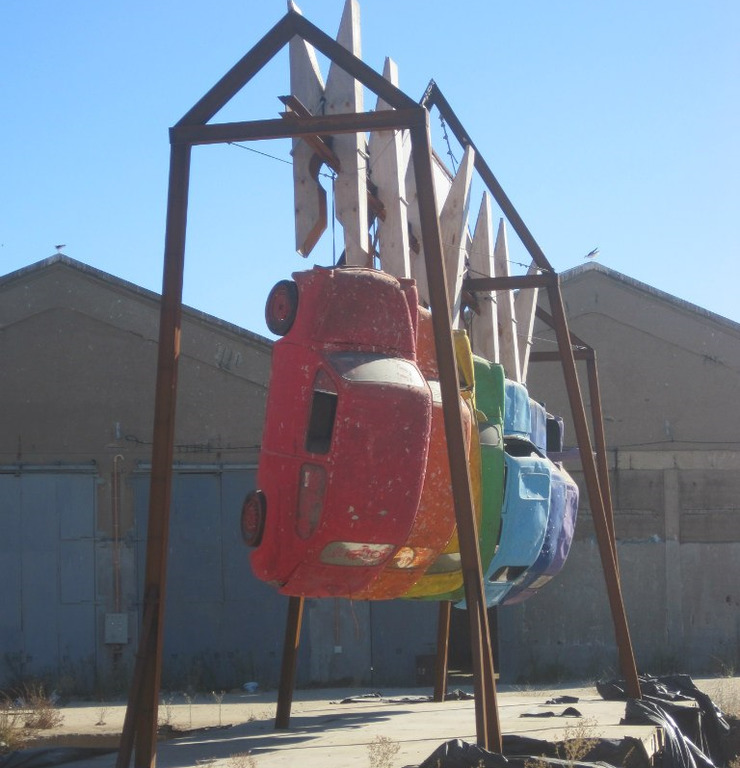

## Introduction
The goal of this project is to predict a car's market price using its attributes and applying k-nearest neighbors (KNN) algorithm of machine learning (ML). The dataset can be downloaded from [this repository](https://archive.ics.uci.edu/ml/datasets/automobile), where we can also find all its details and the data description. The dataset contains information on various cars, including the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, etc.
### Summary of Results
The best predictive capacity for the car price was obtained for a multivariate model with 4 features (`engine-size`, `curb-weight`, `horsepower`, and `highway-mpg`) created by applying k-fold cross-validation, with 7 folds, and 4 nearest neighbors. It demonstrated the lowest error while still having reasonable values of the number of folds and the nearest neighbors.
## Data Downloading and Initial Exploration
Since the dataset doesn't have a header row, we'll take the column names directly from the documentation:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 
           'aspiration', 'num-of-doors', 'body-style', 'drive-wheels',
           'engine-location', 'wheel-base', 'length', 'width', 'height', 
           'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size',
           'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower',
           'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars = pd.read_csv('imports-85.data', names=columns)

# Displaying all the columns of the dataframe
pd.set_option('max_columns', cars.shape[1])
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [2]:
print(f'\033[1mNumber of rows:\033[0m\t\t  {cars.shape[0]:,}'
      f'\033[1m\nNumber of columns:\033[0m \t  {cars.shape[1]:,}'
      f'\n\033[1mNumber of missing values:\033[0m {cars.isnull().sum().sum()}')

Number of rows:		  205
Number of columns: 	  26
Number of missing values: 0


**Observations:**
- We don't have any NaN values in the dataframe. However, in the `normalized-losses` column, there are missing values represented by "?". Since we can't have any missing values for creating a predictive ML model, we'll have to fix it later.
- There are 205 entries (cars) in the dataframe.
- From 26 columns, we need only numeric ones that can be used as features. The target column is, evidently, `price`. Let's determine which columns are numeric from the [documentation](https://archive.ics.uci.edu/ml/datasets/automobile) and keep only them in the dataframe:

In [3]:
numeric_columns = ['normalized-losses', 'wheel-base', 'length', 'width', 
                   'height', 'curb-weight', 'engine-size', 'bore', 'stroke',
                   'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg',
                   'highway-mpg', 'price']
cars = cars[numeric_columns]
cars.shape

(205, 15)

## Data Cleaning
Earlier, we noticed the presence of missing values represented by "?" in the first 5 rows of the `normalized-losses` column. Probably, also some other columns contain such values. Let's replace the "?" values with NaN in the whole dataframe and double-check it for the presence of missing values again:

In [4]:
# Replacing "?" with NaN and rendering all the columns float
cars = cars.replace('?', np.nan).astype('float')
print('\n\033[1mMissing values after replacing the "?" values, %\033[0m')

# Showing missing values in %
round(cars.isnull().sum()*100/len(cars)).astype('int')


Missing values after replacing the "?" values, %


normalized-losses    20
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  2
stroke                2
compression-rate      0
horsepower            1
peak-rpm              1
city-mpg              0
highway-mpg           0
price                 2
dtype: int32

Now, the `normalized-losses` column contains most of all missing values (20%), while the others – from 0 to 2%. Dropping the rows with the missing values entirely doesn't make sense: we would lose the valid data from the other columns that are almost complete. Dropping the whole column `normalized-losses` isn't a good idea either: 80% of its data is valid and can be used for modeling. The most reasonable approach here is to substitute all the missing values with the mean value of each corresponding column:

In [5]:
cars = cars.fillna(cars.mean())
print(f'\033[1mNumber of missing values in the dataframe:\033[0m {cars.isnull().sum().sum()}')

Number of missing values in the dataframe: 0


Next, we're going to normalize the values in all the numeric columns except for the target one (`price`):

In [6]:
price = cars['price']

# Normalizing numeric columns
cars = (cars-cars.min())/(cars.max()-cars.min())

# Keeping initial price values
cars['price'] = price

cars.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.262500,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.262500,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,0.125,0.441667,0.346939,0.166667,0.263158,16500.0


Now, the data is clean and ready for further modeling. We're going to use 2 ML approaches: **test/train validation** and **k-fold cross-validation**. For both approaches, we'll create both uni- and multivariate KNN models, estimate the error for  each case, and select the best model (with the lowest error).
##  Test/Train Validation
### Creating Univariate Models
Let's start with creating simple univariate KNN models, one for each numeric column. As an evaluation metric, we'll use RMSE:

In [7]:
def knn_train_test(train_cols, target_col, df, k=5):
    '''Takes in a train column/columns, the target column, the dataframe, 
    and the number of the nearest neighbors. Trains and tests the model 
    using test/train validation approach. Returns RMSE value.
    '''
    
    # One-column case
    if type(train_cols)==str:
        X_train, X_test, y_train, y_test = train_test_split(df[[train_cols]], df[target_col],
                                                        test_size=0.5, random_state=1)
    # Multi-column case
    elif type(train_cols)==list:
        X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[target_col],
                                                            test_size=0.5, random_state=1)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse**(0.5)


rmse_default_k = {}

# Isolating all the numeric columns except for `price` as train columns
train_cols = cars.columns.drop('price')

# Creating a univariate model for each column using the default value of k 
# and adding each RMSE to the dictionary
for col in train_cols:
    rmse = knn_train_test(col, 'price', cars)
    rmse_default_k[col] = round(rmse)

# Sorting the dictionary by RMSE in ascending order
sorted_rmse_default_k = dict(sorted(rmse_default_k.items(), 
                                    key=operator.itemgetter(1)))
sorted_rmse_default_k

{'engine-size': 3345,
 'curb-weight': 4172,
 'width': 4341,
 'city-mpg': 4433,
 'horsepower': 4539,
 'highway-mpg': 4696,
 'compression-rate': 5463,
 'wheel-base': 5640,
 'length': 5853,
 'bore': 6590,
 'normalized-losses': 6756,
 'stroke': 7004,
 'height': 7319,
 'peak-rpm': 7589}

Using the default number of neighbors (k=5), we can conclude that the univariate model with `engine-size` variable performed the best, demonstrating the lowest error and, hence, the highest predictive capacity for the price. However, let's try to vary the values of k for each variable and observe the results:

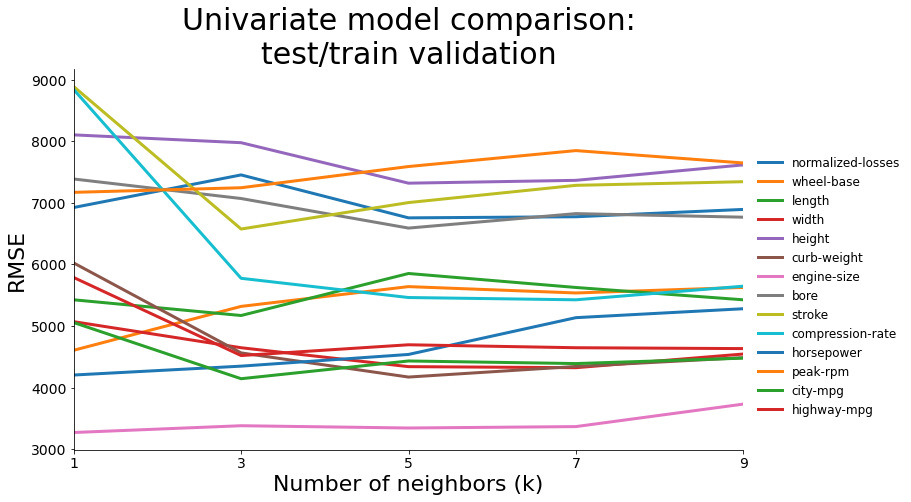

In [8]:
rmse_various_k = {}

plt.figure(figsize=(12,7))

# Creating univariate models for each column with various values of k, 
# adding each RMSE to the dictionary, and plotting the results for all variables
for col in train_cols:
    rmse_various_k[col] = []
    for k in [1, 3, 5, 7, 9]:
        rmse = knn_train_test(col, 'price', cars, k)
        rmse_various_k[col].append(round(rmse))
    plt.plot(list(range(1,10, 2)), rmse_various_k[col], linewidth=3)
plt.title('Univariate model comparison:\ntest/train validation', fontsize=30)
plt.xlabel('Number of neighbors (k)', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.xticks([1,3,5,7,9], fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1,9)
plt.legend(train_cols, frameon=False, bbox_to_anchor=(1.25, 0.8), fontsize=12)
sns.despine()
plt.show()

From the "spaghetti chart" above, we clearly see that among all the univariate models, the ones with the `engine-size` column performed the best again, with any k value from our selection. For k=1, though, it demonstrates even lower RMSE than in the previous case (k=5). The difference, however, isn't considerable:

In [9]:
k_1 = rmse_various_k['engine-size'][0]
k_5 = rmse_various_k['engine-size'][2]
print(f'\033[1mRMSE for the univariate models with `engine-size`:\033[0m'
      f'\nk=1: {k_1}'
      f'\nk=5: {k_5}')

RMSE for the univariate models with `engine-size`:
k=1: 3272
k=5: 3345


### Creating Multivariate Models
Next, let's create some multivariate models. First, we're going to try different combinations of the best features (with the lowest average RMSE) from the previous step to train and test a multivariate KNN model using the default k value (k=5): 2, 3, 4, and 5 best features:

In [10]:
rmse_various_k_mean = {}

# Finding the mean value of RMSE for each variable
for key in rmse_various_k:
    rmse_various_k_mean[key] = np.mean(rmse_various_k[key])

# Sorting the dictionary by RMSE in ascending order
sorted_rmse_various_k_mean = dict(sorted(rmse_various_k_mean.items(), 
                                         key=operator.itemgetter(1)))
sorted_rmse_various_k_mean

{'engine-size': 3420.0,
 'city-mpg': 4501.0,
 'width': 4586.0,
 'horsepower': 4702.0,
 'curb-weight': 4718.2,
 'highway-mpg': 4857.4,
 'wheel-base': 5346.0,
 'length': 5500.4,
 'compression-rate': 6230.0,
 'bore': 6927.8,
 'normalized-losses': 6960.0,
 'stroke': 7418.6,
 'peak-rpm': 7499.8,
 'height': 7675.8}

The 5 best features are: `engine-size`, `city-mpg` (mileage), `width`, `horsepower`, `curb-weight` (the vehicle's weight on the curb). Hence, we have to consider the following combinations:
- `engine-size`, `city-mpg`


- `engine-size`, `city-mpg`, `width`


- `engine-size`, `city-mpg`, `width`, `horsepower`


- `engine-size`, `city-mpg`, `width`, `horsepower`, `curb-weight`

In [11]:
rmse_multivariate = []

for i in [2,3,4,5]:
    
    # Selecting from 2 to 5 best features
    train_cols_list = list(sorted_rmse_various_k_mean.keys())[:i]
    
    # Creating a multivariate model for each combination of features using 
    # the default k=5 and rounding the resulting RMSE
    rmse = round(knn_train_test(train_cols_list, 'price', cars))
    
    # Appending the RMSE value of each multivariate model to the list
    rmse_multivariate.append(rmse)
        
rmse_multivariate

[3320, 3896, 3760, 3677]

The TOP3 models with the lowest RMSE from the previous step are:
1. With 2 best features (`engine-size`, `city-mpg`) and RMSE=3320.
2. With 5 best features (`engine-size`, `city-mpg`, `width`, `horsepower`, `curb-weight`) and RMSE=3677.
3. With 4 best features (`engine-size`, `city-mpg`, `width`, `horsepower`) and RMSE=3760.

As we did for the univariate models, let's tune the hyperparameter k for each of these TOP3 models and observe the results:

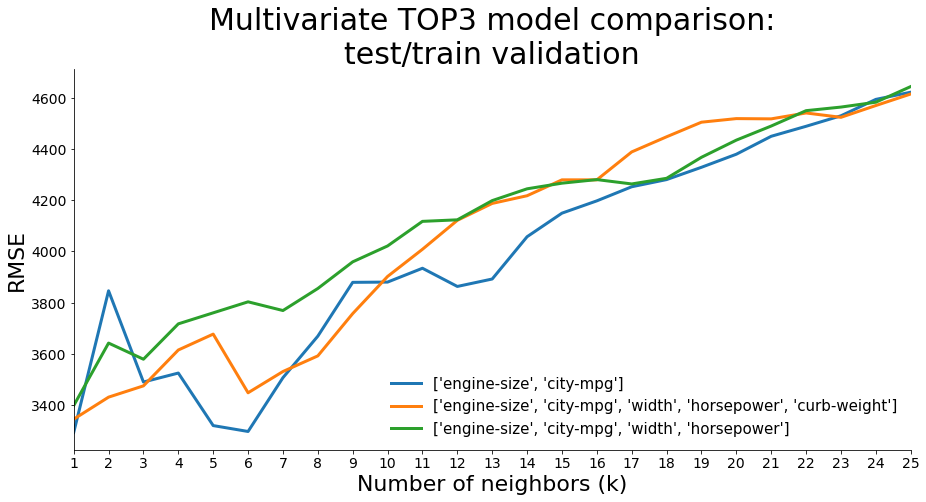

In [12]:
train_cols_list = [['engine-size', 'city-mpg'],
                   ['engine-size', 'city-mpg', 'width', 'horsepower', 'curb-weight'],
                   ['engine-size', 'city-mpg', 'width', 'horsepower']]
rmse_multivar_various_k = {}

plt.figure(figsize=(15,7))

# Creating multivariate models for each feature combination with k from 1 to 25, 
# adding each RMSE to the dictionary, and plotting the results for all the models
for ind, lst in enumerate(train_cols_list):
    rmse_multivar_various_k[ind+1] = []
    for k in list(range(1,26)):
        rmse = knn_train_test(lst, 'price', cars, k)
        rmse_multivar_various_k[ind+1].append(round(rmse))
    plt.plot(list(range(1,26)), rmse_multivar_various_k[ind+1], linewidth=3)
plt.title('Multivariate TOP3 model comparison:\ntest/train validation', fontsize=30)
plt.xlabel('Number of neighbors (k)', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.xlim(1,25)
plt.xticks(list(range(1,26)), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(train_cols_list, frameon=False, loc=4, bbox_to_anchor=None, fontsize=15)
sns.despine()
plt.show()

**Observations:**
- The 2-feature model remains the best one, with the optimal number of neighbors k equal to 6. For smaller values of k, with some fluctuations, the error is decreasing down to the minimum value at k=6, Then, it starts constantly increasing. The minimum value of RMSE:

In [13]:
np.min(rmse_multivar_various_k[1])

3293

- For the other 2 graphs (4- and 5-feature models), the lowest value of error (still higher than the one for the 2-feature model) is related to k=1. For higher values of k, the RMSE is constantly increasing.
- In practice, considering too few neighbors (i.e. too small values of k) implies a high impact of noise on the result. Instead, considering too many neighbors results in involving irrelevant neighbors from other clusters (and indeed, for higher values of k, the error is constantly increasing). 

Since our goal is to select the model with the smallest error and, hence, the highest predictive capacity for the car price, let's review our best results so far:
- **Univariate models:**
    - Default k=5: `engine-size` (RMSE=3345).
    - Optimal k=1: `engine-size` (RMSE=3272).
- **Multivariate models:**
    - Default k=5: `engine-size` and `city-mpg` (RMSE=3320).
    - Optimal k=6 `engine-size` and `city-mpg` (RMSE=3293).
    
In general, the difference between all the RMSE values above isn't considerable. The lowest RMSE is related to the univariate model with `engine-size` and k=1. However, as we mentioned earlier, considering too few nearest neighbors leads to the noise influence. Hence, a safer choice is the second best **multivariate model with `engine-size` & `city-mpg` and RMSE=3293**.

##  K-Fold Cross-Validation
### Creating Univariate Models
Now, we'll create univariate KNN models using k-fold cross-validation approach. This time, we won't vary the number of the nearest neighbors leaving it equal to the default value k=5 (**where k is the number of the nearest neighbors, not the number of folds**). Instead, let's vary the number of folds and visualize the results:

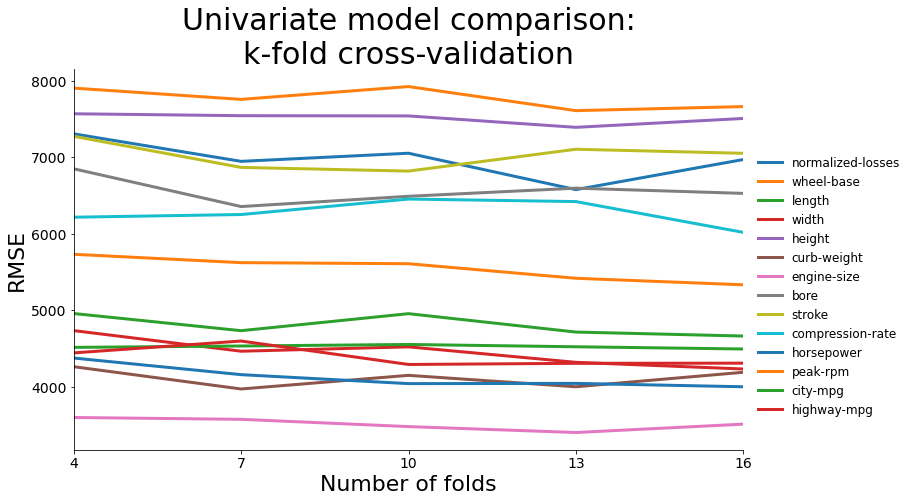

{'engine-size': 3517.8,
 'curb-weight': 4118.2,
 'horsepower': 4127.6,
 'highway-mpg': 4392.8,
 'width': 4457.8,
 'city-mpg': 4526.6,
 'length': 4807.6,
 'wheel-base': 5544.4,
 'compression-rate': 6272.6,
 'bore': 6563.8,
 'normalized-losses': 6970.0,
 'stroke': 7022.8,
 'height': 7508.8,
 'peak-rpm': 7769.6}

In [14]:
def k_fold_cross_val(n_splits, train_cols, target_col, df, k=5):
    '''Takes in the number/numbers of folds as an integer or a list 
    correspondingly, a train column/columns, the target column, 
    the dataframe, and the number of the nearest neighbors. Trains and tests
    the model using k-fold cross-validation approach. Returns RMSE value.
    '''
    
    # One number of folds
    if type(n_splits)==int:
        kf = KFold(n_splits, shuffle=True, random_state=1)
        knn = KNeighborsRegressor(n_neighbors=k)
        
        # One-column case
        if type(train_cols)==str:
            mses = cross_val_score(knn, df[[train_cols]], df['price'],
                                   scoring='neg_mean_squared_error', cv=kf)
        
        # Multi-column case
        elif type(train_cols)==list:
            mses = cross_val_score(knn, df[train_cols], df['price'],
                                   scoring='neg_mean_squared_error', cv=kf)
        return np.mean(abs(mses)**0.5)
    
    # Several numbers of folds
    if type(n_splits)==list:
        for n in n_splits:
            kf = KFold(n, shuffle=True, random_state=1)
            knn = KNeighborsRegressor(n_neighbors=k)
            
            # One-column case
            if type(train_cols)==str:
                mses = cross_val_score(knn, df[[train_cols]], df['price'], 
                                       scoring='neg_mean_squared_error', cv=kf)
                
            # Multi-column case
            elif type(train_cols)==list:
                mses = cross_val_score(knn, df[train_cols], df['price'], 
                                       scoring='neg_mean_squared_error', cv=kf)
            rmses = np.sqrt(np.absolute(mses))
            avg_rmse = np.mean(rmses)
            std_rmse = np.std(rmses)
            print(f'{n} folds: \navg_RMSE={round(avg_rmse)}, std_RMSE={round(std_rmse)}')
            
            
rmse_kfold_univar = {}

plt.figure(figsize=(12,7))

# Creating univariate models for each column using k-fold cross-validation, 
# the default k and various numbers of folds, adding each RMSE to the dictionary,
# and plotting the results
for col in train_cols:
    rmse_kfold_univar[col] = []
    for n in [4, 7, 10, 13, 16]:
        rmse = k_fold_cross_val(n, col, 'price', cars)
        rmse_kfold_univar[col].append(round(rmse))
    plt.plot(list(range(4,17, 3)), rmse_kfold_univar[col], linewidth=3)
plt.title('Univariate model comparison:\nk-fold cross-validation', fontsize=30)
plt.xlabel('Number of folds', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.xticks([4, 7, 10, 13, 16], fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(4,16)
plt.legend(train_cols, frameon=False, bbox_to_anchor=(1.25, 0.8), fontsize=12)
sns.despine()
plt.show()

rmse_kfold_univar_mean = {}

# Finding the mean value of RMSE for each variable
for key in rmse_kfold_univar:
    rmse_kfold_univar_mean[key] = np.mean(rmse_kfold_univar[key])

# Sorting the dictionary by RMSE in ascending order
sorted_rmse_kfold_univar_mean = dict(sorted(rmse_kfold_univar_mean.items(),
                                            key=operator.itemgetter(1)))
sorted_rmse_kfold_univar_mean

Both from the "spaghetti chart" and the mean values of RMSE for each variable, we deduce once again that the univariate model with the `engine-size` column demonstrates the lowest RMSE with any number of folds from our selection (the minimum error with the number of folds equal to 13) and, hence, performs best of all for predicting car prices.

### Creating Multivariate Models
Let's now create some multivariate models. We'll apply the following algorithm: 
- Select 5 best features from the previous step: `engine-size`, `curb-weight`, `horsepower`, `highway-mpg`, and `width`.
- Try different combinations of them: 2, 3, 4, and 5 best features:
    -  `engine-size`, `curb-weight`
    -  `engine-size`, `curb-weight`, `horsepower`
    -  `engine-size`, `curb-weight`, `horsepower`, `highway-mpg`
    -  `engine-size`, `curb-weight`, `horsepower`, `highway-mpg`, `width`.
    
    
- Vary the number of folds (the same selection as we used for the univariate models: 4, 7, 10, 13, 16).
- Vary the number of the nearest neighbors from 3 to 10.
- Train and test a multivariate KNN model for each combination of features, using different numbers of folds and nearest neighbors.
- Visualize the results (each figure will represent all 4 combinations of features, with all the options of the fold numbers from the selection and a fixed number of the nearest neighbors).

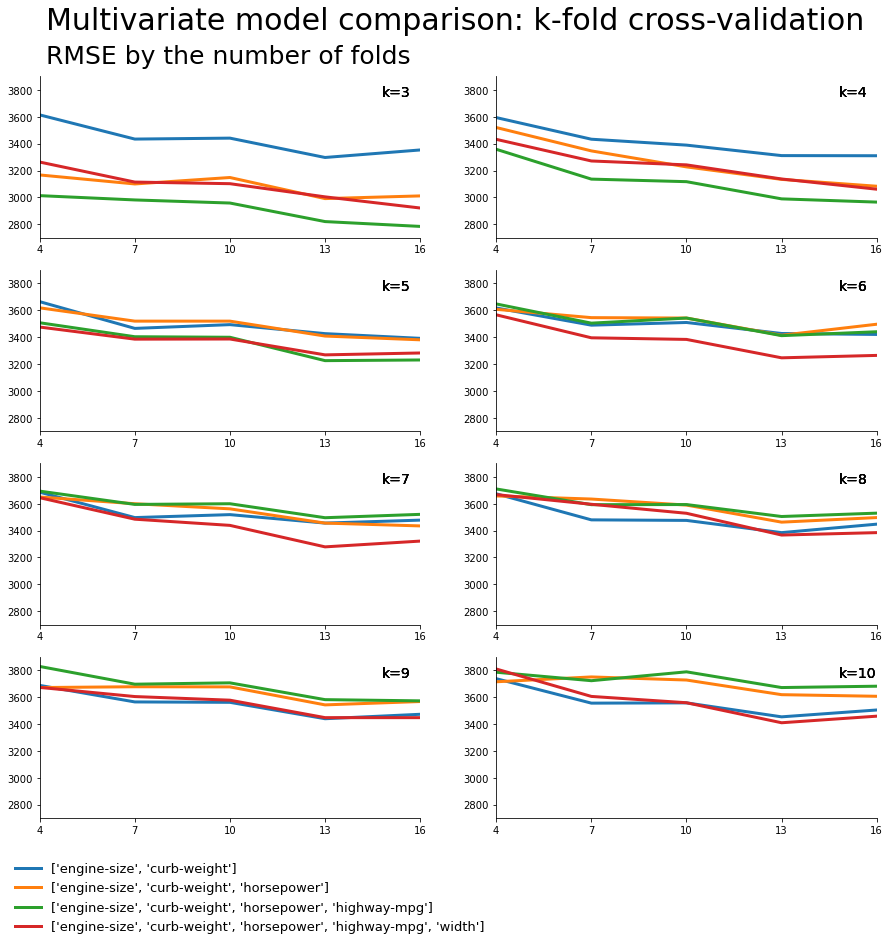

In [15]:
train_cols_list = [['engine-size', 'curb-weight'],
                   ['engine-size', 'curb-weight', 'horsepower'],
                   ['engine-size', 'curb-weight', 'horsepower', 'highway-mpg'],
                   ['engine-size', 'curb-weight', 'horsepower', 'highway-mpg', 'width']]
rmse_kfold_multivar = {}

plt.figure(figsize=(15,35))

# Creating multivariate models for each feature combination using k-fold 
# cross-validation, various numbers of folds and the nearest neighbors, 
# adding each RMSE to the dictionary, and plotting the results
for k in range(3,11):
    plt.subplot(10, 2, k-2)
    for ind, lst in enumerate(train_cols_list):
        rmse_kfold_multivar[ind+1] = []
        for n in [4, 7, 10, 13, 16]:
            rmse = k_fold_cross_val(n, lst, 'price', cars, k)
            rmse_kfold_multivar[ind+1].append(round(rmse))
        plt.plot([4, 7, 10, 13, 16], rmse_kfold_multivar[ind+1], linewidth=3)
        plt.text(14.8, 3750, f'k={k}', fontsize=14)
    if k==10:
        plt.legend(train_cols_list, frameon=False, bbox_to_anchor=(0,-0.2), fontsize=13)
        plt.text(-10.2, 8570,'Multivariate model comparison: k-fold cross-validation', fontsize=30)
        plt.text(-10.2, 8320,'RMSE by the number of folds', fontsize=25)
    plt.xticks([4, 7, 10, 13, 16], fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(2700,3900)
    plt.xlim(4,16)
    sns.despine()
plt.show()

**Observations:**
- Increasing the number of folds leads to decreasing the error of price prediction **on the test set** for all the models. It's explainable: in this case, we over-fit the model. However, such model a can demonstrate poor performance on completely new data.
- Increasing the number of the nearest neighbors leads, in the longer term, to the increase of the error of price prediction (because of involving irrelevant neighbors). It's especially evident for the models with more features that are more sensitive to the changes of k. To reduce the error, keeping at the same time as many features for price prediction as reasonably possible, we have to consider relatively low k values.
- It's important to remember that we have only 205 entries in our dataset, that is not too many. To avoid model over-fitting, we'd better consider relatively low values of the number of folds.

Hence, the **model with the 4 best features (`engine-size`, `curb-weight`, `horsepower`, and `highway-mpg`), 7 folds, and 4 nearest neighbors is an excellent candidate**. Indeed, of all the models we created so far, this one has the lowest RMSE value, while still having reasonable values of the number of folds and the nearest neighbors:

In [16]:
# Calsulation the RMSE value of the model that performed best of all
rmse = round(k_fold_cross_val(7, ['engine-size', 'curb-weight', 'horsepower', 'highway-mpg'], 'price', cars, 4))
print(f'\033[1mRMSE=\033[0m{rmse}')

RMSE=3136


## Conclusion
In this project, we used the KNN algorithm, in particular test/train validation and k-fold cross-validation, to create uni- and multivariate ML models for predicting a car's market price based on its attributes. We tried different features and their combinations, different numbers of folds and the nearest neighbors. The main idea  was to reduce the error of prediction on the test data and to ensure model feasibility for future unknown data (by avoiding model over-fitting).

As a result, the best predictive capacity for the car price was obtained for a multivariate model with 4 features (`engine-size`, `curb-weight`, `horsepower`, and `highway-mpg`) created by applying k-fold cross-validation, with 7 folds, and 4 nearest neighbors. Its main advantages are:
- the lowest RMSE value while still having reasonable values of the number of folds and the nearest neighbors,
- using several price-influencing features,
- k-fold cross-validation is less biased than test/train validation since it takes advantage of a larger proportion of the data for training while still iterating through different data subsets.

This model, as well as the others that have demonstrated the lowest error, has `engine-size` as one of the features. Hence, the engine size is one of the most influencing factors on the car price.